In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 264, 6, Finished, Available, Finished)

StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 264, 9, Finished, Available, Finished)

Sample Aggregated Data:
            estimated_emissions  average_speed  congestion_surcharge  \
date                                                                   
2020-01-31           520.345407      11.348412              0.804328   
2020-02-29           519.176150      11.330530              0.794997   
2020-03-31           541.209385      11.845373              0.707791   
2020-04-30           620.618757      13.758839              0.691062   
2020-05-31           621.541527      13.642517              0.711621   

            driver_pay  
date                    
2020-01-31    2.433957  
2020-02-29    2.473833  
2020-03-31    2.508037  
2020-04-30    2.497540  
2020-05-31    2.505447  


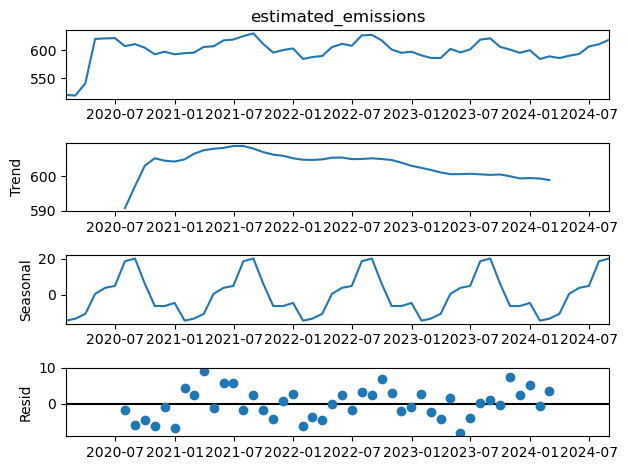

                                     SARIMAX Results                                      
Dep. Variable:                estimated_emissions   No. Observations:                   56
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -92.763
Date:                            Wed, 04 Dec 2024   AIC                            195.526
Time:                                    04:21:42   BIC                            202.362
Sample:                                01-31-2020   HQIC                           197.667
                                     - 08-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1359      0.268      0.506      0.613      -0.390       0.662
ma.L1         -1.0000   1655.301   

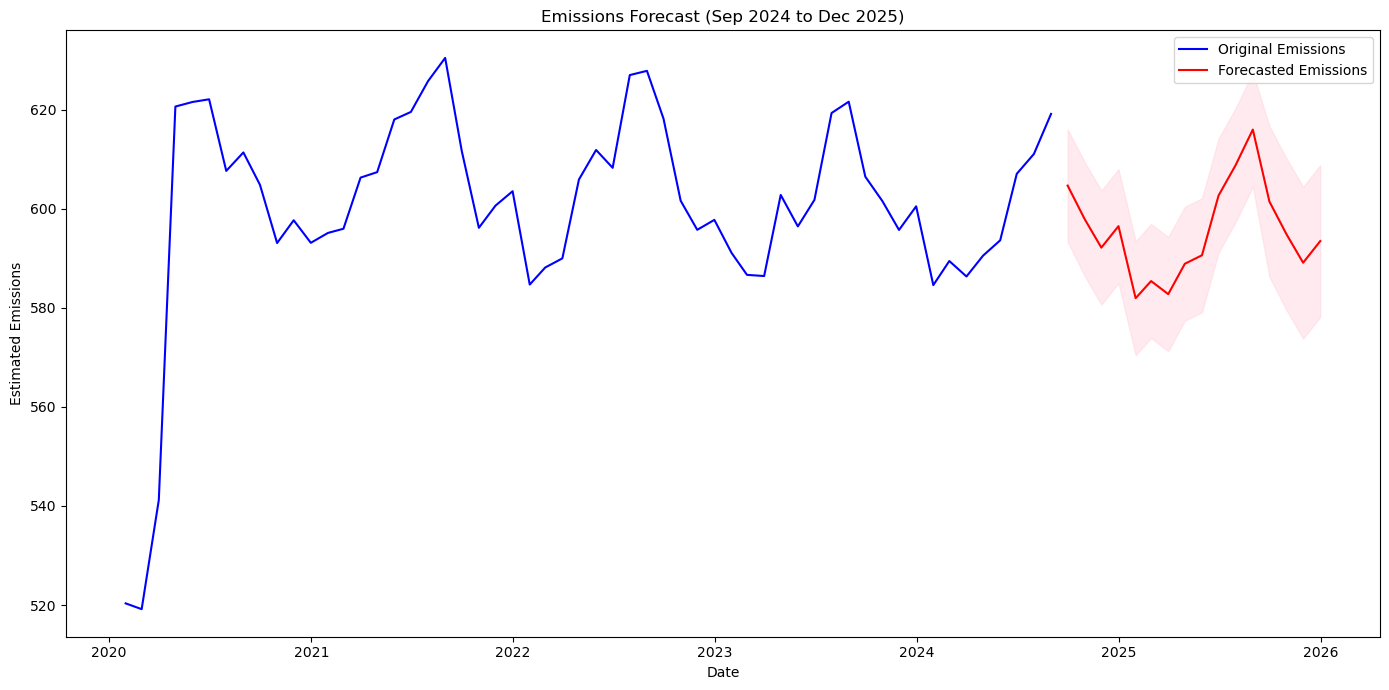

In [4]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. Load and Preprocess Data
df = pd.read_parquet("Uberdata.parquet")
df = df.drop(['dispatching_base_num', 'originating_base_num','request_datetime',
              'on_scene_datetime', 'pickup_datetime','dropoff_datetime'], axis=1)

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Define a function for monthly aggregation
def prepare_monthly_data(df):
    agg_dict = {
        'estimated_emissions': 'mean',
        'average_speed': 'mean',
        'congestion_surcharge': 'mean',
        'driver_pay': 'mean'
    }
    # Resample to monthly frequency and aggregate
    df_monthly = df.set_index('date').resample('M').agg(agg_dict)
    return df_monthly

# Aggregate data to monthly frequency
df_monthly = prepare_monthly_data(df)

# Drop rows with missing values
df_monthly = df_monthly.dropna()

# Prepare the target variable
target = df_monthly['estimated_emissions']

# Display the first few rows of aggregated data
print("Sample Aggregated Data:")
print(df_monthly.head())

# 2. Seasonal Decomposition 
decomposition = seasonal_decompose(target, model='additive', period=12)
decomposition.plot()
plt.show()

# 3. Train-Test Split
train_target = target 

# 4. Fit SARIMA Model
sarima_model = SARIMAX(
    train_target,
    order=(1, 1, 1),  
    seasonal_order=(1, 1, 1, 12), 
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_results = sarima_model.fit(disp=False)
print(sarima_results.summary())

# 5. Forecast for Sep 2024 to Dec 2025
# Forecast for 16 steps (Sep 2024 to Dec 2025)
forecast_steps = 16
forecast = sarima_results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# 6. Create Forecast Index for Visualization
forecast_index = pd.date_range(start='2024-09-30', end='2025-12-31', freq='M')

# Combine forecast into a DataFrame
forecast_df = pd.DataFrame({
    'Forecasted Emissions': forecast_mean.values,
    'Lower CI': forecast_ci.iloc[:, 0].values,
    'Upper CI': forecast_ci.iloc[:, 1].values
}, index=forecast_index)

print("\nForecasted Values:")
print(forecast_df)

# 7. Plot the Forecast
plt.figure(figsize=(14, 7))

# Plot historical data
plt.plot(target.index, target, label='Original Emissions', color='blue')

# Plot forecast
plt.plot(forecast_index, forecast_mean, color='red', label='Forecasted Emissions')

# Add confidence intervals
plt.fill_between(
    forecast_index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='pink',
    alpha=0.3
)

plt.title('Emissions Forecast (Sep 2024 to Dec 2025)')
plt.xlabel('Date')
plt.ylabel('Estimated Emissions')
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Get residuals: actual - fitted values
residuals = train_target - sarima_results.fittedvalues

# Calculate RMSE and MAE for training data
mae = mean_absolute_error(train_target, sarima_results.fittedvalues)
rmse = np.sqrt(mean_squared_error(train_target, sarima_results.fittedvalues))

print("\nTraining Data Accuracy Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 264, 10, Finished, Available, Finished)


Training Data Accuracy Metrics:
Mean Absolute Error (MAE): 24.8284
Root Mean Squared Error (RMSE): 84.0476
